# Fase Gas
$\rho^\star = 0.05$, $T^\star = 1.2$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
from decimal import Decimal as d

## Equilibrazione
Di seguito sono mostrati i grafici dei valori istantanei di energia interna per particella $U/N$ e pressione $P$ in funzione del numero di passi MC dall'inizio della simulazione per mostrare il tempo impiegato dal sistema ad equilibrare.
Configurazione di partenza: configurazione finale della simulazione del liquido.

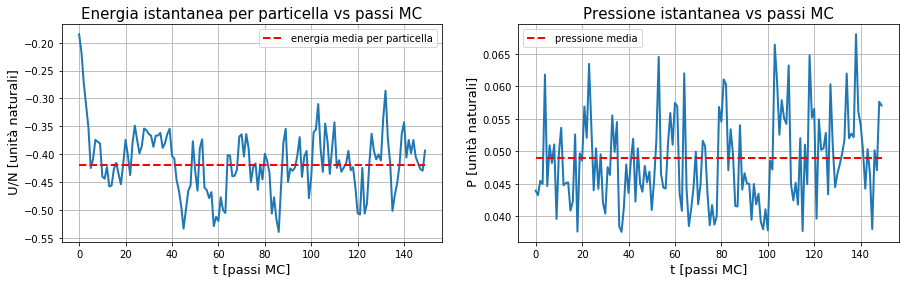

In [3]:
# caricamento da file: energia istantanea vs passi MC
rows = 150
epot_eq = np.loadtxt("Gas/Equilibration/epot_instant.txt", usecols=(0), delimiter = ' ', unpack = 'true',max_rows=rows)
x = np.arange(len(epot_eq))
epot_mean = np.loadtxt("Gas/Average/epot.txt", usecols=(0), unpack = 'true')
N = len(epot_mean)

# caricamento da file: pressione istantanea vs passi MC
pres_eq = np.loadtxt("Gas/Equilibration/pres_instant.txt", usecols=(0), delimiter = ' ', unpack = 'true',max_rows=rows)
pres_mean = np.loadtxt("Gas/Average/pres.txt", usecols=(0), unpack = 'true')

instant = [epot_eq,pres_eq]
mean = [epot_mean,pres_mean]
label = ['energia media per particella','pressione media']
ylabel = [' U/N [unità naturali]',' P [unità naturali]']
title =['Energia istantanea per particella vs passi MC','Pressione istantanea vs passi MC']

# plot
f = plt.figure(figsize=(15,4))
for i in range(2):
    f.add_subplot(1,2,i+1)
    plt.plot(x,instant[i],linewidth=2)
    plt.plot(x,np.ones(rows)*mean[i][N-1],color='red',label=label[i], linestyle='dashed',linewidth=2)
    plt.xlabel('t [passi MC]',size=13)
    plt.ylabel(ylabel[i],size=13)
    plt.title(title[i],size=15)
    plt.grid(True)
    plt.legend()
plt.show()

In pochi passi MC, meno di 50, i valori istantanei di $U/N$ e $P$ fluttuano attorno al loro valor medio di equilibrio. 

## Funzione di autocorrelazione e tempo di correlazione
Le funzioni di autocorrelazione temporale di $U/N$ e $P$ sono state calcolate per il range di tempo $[0,200]$ e il loro grafico è riportato di seguito.

In [7]:
# funzione di autocorrelazione
def Correlation(t,t_max,quantity): 
    Sum = np.zeros(5)
    
    for i in range(t_max):
        Sum[0] += quantity[i]
        Sum[1] += quantity[i] * quantity[i]

    for i in range(t_max - t):
        Sum[2] += quantity[i] * quantity[i + t]
        Sum[3] += quantity[i]
        Sum[4] += quantity[i + t]
        
    Sum[0] = (Sum[0]/t_max) * (Sum[0]/t_max)
    Sum[1] = Sum[1]/t_max
    Sum[2] = Sum[2]/(t_max - t)
    Sum[3] = Sum[3]/(t_max - t)
    Sum[4] = Sum[4]/(t_max - t)

    return (Sum[2] - Sum[3]*Sum[4])/(Sum[1] - Sum[0])

# funzione esponenziale per fit
def Exp(x,a):
    return np.exp(- x/a)

In [8]:
t_max = 100000
N = 200
t1 = np.arange(N)
Chi_epot = []
Chi_pres = []

# caricamento da file: energia e pressione istantanee vs passi MC
epot_instant = np.loadtxt("Gas/Instant/epot_instant.txt", usecols=(0), unpack = 'true')
pres_instant = np.loadtxt("Gas/Instant/pres_instant.txt", usecols=(0), unpack = 'true')

# calcolo funzioni di autocorrelazione 
for i in range(N):
    Chi_epot.append(Correlation(i,t_max,epot_instant))
    Chi_pres.append(Correlation(i,t_max,pres_instant))

In [9]:
# fit funzioni di autocorrelazione con funzione esponenziale
p_opt_epot, p_cov_epot = curve_fit(Exp, t1, Chi_epot)
Fit_Chi_epot = Exp(t1,p_opt_epot[0])
p_opt_pres, p_cov_pres = curve_fit(Exp, t1, Chi_pres)
Fit_Chi_pres = Exp(t1,p_opt_pres[0])

Chi = [Chi_epot,Chi_pres]
Fit_Chi = [Fit_Chi_epot,Fit_Chi_pres]
title = ['energia potenziale','pressione']

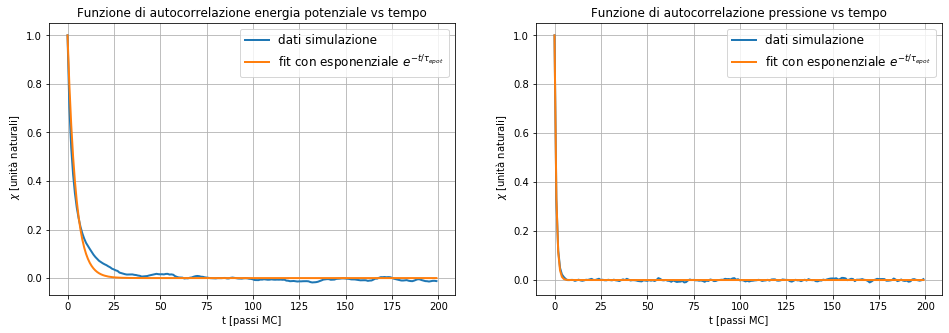

tempo di correlazione U/N: τ_epot = 4.3
tempo di correlazione P: τ_pres = 0.9


In [10]:
# plot    
f = plt.figure(figsize=((16,5)))    
for i in range(2):
    f.add_subplot(1,2,i+1)
    plt.plot(t1,Chi[i],linewidth=2,label='dati simulazione')
    plt.plot(t1,Fit_Chi[i], label = "fit con esponenziale $e^{-t/\u03C4_{epot}}$",linewidth=2)
    plt.xlabel('t [passi MC]')
    plt.ylabel(' $\chi$ [unità naturali]')
    plt.title('Funzione di autocorrelazione '+title[i]+' vs tempo')
    plt.grid(True)
    plt.legend(prop={'size':12})

plt.show()

print("tempo di correlazione U/N: \u03C4_epot =", round(p_opt_epot[0],1))
print("tempo di correlazione P: \u03C4_pres =", round(p_opt_pres[0],1))

La funzione di correlazione del gas, grazie anche alla scelta di un passo piuttosto grande, decade più velocemente rispetto a quella del solido e, soprattutto, del liquido. In meno di $100$ passi MC le correlazioni di $U/N$ e $P$ sono totalmente estinte.

## Data blocking e incertezza statistica
Si riportano i grafici dell'incertezza statistica $\sigma_L$ dei valori medi $\langle U/N\rangle$ e $\langle P\rangle$ stimata con il metodo del blocking in funzione del numero di passi temporali $L$ in ciascun blocco mantenendo il numero totale di passi costante ($M=10^5$). Sono stati scelti 100 valori di $L$ distribuiti uniformemente nel range $[10,5\cdot 10^3]$ ma nei grafici viene mostrato il range in cui $\sigma_L$ aumenta e raggiunge - all'incirca - il valore limite. I valori di $\sigma_L$ sono stati plottati anche in scala logaritmica.

In [11]:
# funzione errore statistico
def Error(AV,AV2,n):
    return math.sqrt((AV2 - AV**2)/n)

# funzione metodo blocking
def Blocking(quantity):
    M = len(quantity) # total MC steps
    n_punti = 100
    
    L = np.zeros(n_punti).astype(int)
    err = np.zeros(n_punti)

    for i in range(n_punti):
        
        L[i] = (i+1)*10
        N = int(M/L[i]) # number of blocks
        ave1 = 0
        ave2 = 0
        for j in range(N):
            mean = 0
            for k in range(L[i]):
                mean += quantity[j*L[i] + k]/L[i]
            ave1 += mean/N
            ave2 += mean*mean/N
        
        err[i] = Error(ave1,ave2,N)
    return L,err;

In [12]:
# calcolo errore statistico per diversi valori di L
L,err_epot = Blocking(epot_instant)
L,err_pres = Blocking(pres_instant)

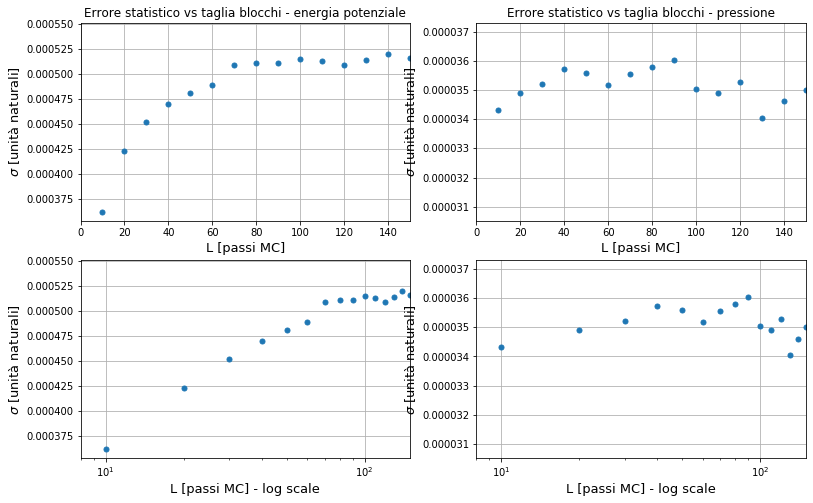

In [13]:
err = [err_epot,err_pres]
title = ['energia potenziale','pressione']

# plot
f = plt.figure(figsize=(13,8))

for i in range(2):
    f.add_subplot(2,2,i+1)
    plt.plot(L,err[i],marker='o',markersize=5,linestyle='None') 
    plt.title('Errore statistico vs taglia blocchi - '+title[i],size=12)
    plt.xlabel('L [passi MC]',size=13)
    plt.ylabel('$\sigma$ [unità naturali]',size=13)
    plt.xlim(0,1.5*10**2)
    plt.grid(True)

for i in range(2):
    f.add_subplot(2,2,i+3)
    plt.plot(L,err[i],marker='o',markersize=5,linestyle='None') 
    plt.xlabel('L [passi MC] - log scale',size=13)
    plt.ylabel('$\sigma$ [unità naturali]',size=13)
    plt.xscale('log')
    plt.xlim(8,1.5*10**2)
    plt.grid(True)
plt.show()

I grafici mostrano che $\sigma_L$ raggiunge velocemente il valore limite, per $L=80$ passi nel caso dell'energia potenziale e ancora prima nel nel caso della pressione. 

## Plot dei valori medi per Argon e Krypton

Si riportano i grafici di $\langle U/N\rangle$ e $\langle P\rangle$ e relative incertezze statistiche ottenute con simulazioni di $1000$ blocchi da $100$ passi. I risultati relativi all'ultimo blocco sono riportati in unità del SI per l'Argon e il Krypton. 

In [14]:
k_B = 1.38065*10**(-23) # J/K
amu = 1.661*10**(-27) # kg/amu

# ARGON: unità di misura SI
sigma_A = 0.34*10**(-9) # m
epsilon_A = 120*k_B # J
T_A = 120 # K
m_A = 39.948*amu # kg
tau_A = sigma_A*m_A**(1/2)*epsilon_A**(-1/2) # s
p_A = epsilon_A*sigma_A**(-3) # Pa

# KRYPTON: unità SI
sigma_K = 0.364*10**(-9) # m
epsilon_K = 164*k_B # J
T_K = 164 # K
m_K = 83.798*amu # kg
tau_K = sigma_K*m_K**(1/2)*epsilon_K**(-1/2) # s
p_K = epsilon_K*sigma_K**(-3) # Pa

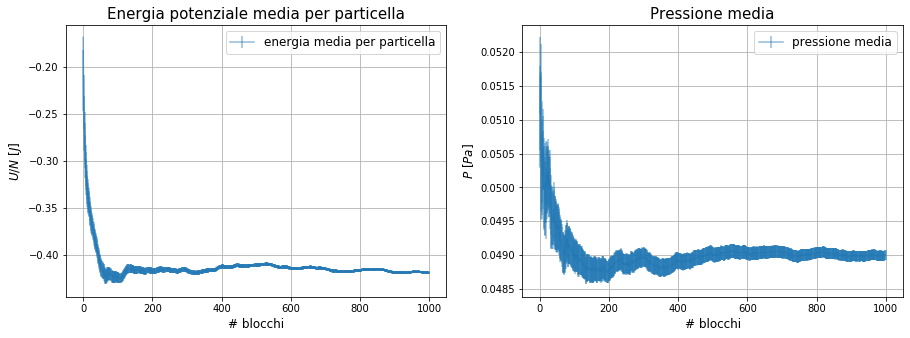

<U/N> (unità ridotte): -0.419 +/- 0.001
<U/N> (Argon): -6.95E-22 +/- 2E-24 J
<U/N> (Krypton): -9.50E-22 +/- 3E-24 J

<P> (unità ridotte): 0.0490 +/- 0.0001
<P> (Argon): 2.066E+6 +/- 3E+3 Pa
<P> (Krypton): 2.301E+6 +/- 4E+3 Pa


In [16]:
# caricamento dati: energia potenziale, pressione, funz di distribuzione radiale
ave_epot,err_ave_epot = np.loadtxt("Gas/Average/epot.txt", usecols=(0,1), unpack = 'true')
ave_pres,err_ave_pres = np.loadtxt("Gas/Average/pres.txt", usecols=(0,1), unpack = 'true')

N = len(ave_epot)
t2 = np.arange(N)

averages = [ave_epot,ave_pres]
err_ave = [err_ave_epot,err_ave_pres]
title = ['Energia potenziale media per particella','Pressione media']
ylabel = ['$U/N$ $[J]$','$P$ $[Pa]$']

# plot
f = plt.figure(figsize=(15,5))

for i in range(2):
    f.add_subplot(1,2,i+1)
    plt.errorbar(t2,averages[i],err_ave[i],label=label[i],alpha=0.5)
    plt.title(title[i],size=15)
    plt.xlabel('# blocchi',size=12)
    plt.ylabel(ylabel[i],size=12)
    plt.grid()
    plt.legend(prop={'size':12})
plt.show()

print('<U/N> (unità ridotte):',round(d(ave_epot[N-1]),3),'+/-',round(d(err_ave_epot[N-1]),3))
print('<U/N> (Argon):',round(d(ave_epot[N-1]*epsilon_A),24),'+/-',round(d(err_ave_epot[N-1]*epsilon_A),24),'J')
print('<U/N> (Krypton):',round(d(ave_epot[N-1]*epsilon_K),24),'+/-',round(d(err_ave_epot[N-1]*epsilon_K),24),'J\n')

print('<P> (unità ridotte):',round(d(ave_pres[N-1]),4),'+/-',round(d(err_ave_pres[N-1]),4))
print('<P> (Argon):',round(d(ave_pres[N-1]*p_A),-3),'+/-',round(d(err_ave_pres[N-1]*p_A),-3),'Pa')
print('<P> (Krypton):',round(d(ave_pres[N-1]*p_K),-3),'+/-',round(d(err_ave_pres[N-1]*p_K),-3),'Pa')

##  Funzione di distribuzione radiale
Infine, si mostra il grafico del valore medio della funzione di distribuzione radiale $g(r)$, che fornisce informazioni sulla struttura microscopica del sistema, dove la distanza tra due particelle $r$ è riportata in unità del SI per l'Argon e il Krypton. Per ottenere la $g(r)$ è stato riempito e opportunamente normalizzato un istogramma di $100$ bin nel range $[0,L_{box}/2]$. 

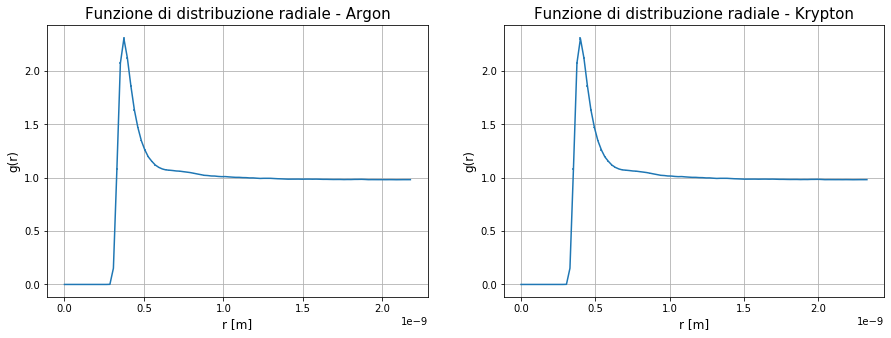

In [17]:
rho = 0.05
n_part = 108
sigma = [sigma_A,sigma_K]
name = ['Argon','Krypton']

gdr,err_gdr = np.loadtxt("Gas/Average/gave.txt", usecols=(1,2), unpack = 'true')

n_bins = len(gdr)
bin_size = (n_part/rho)**(1.0/3.0)/2.0/n_bins
r = np.arange(n_bins)*bin_size

f = plt.figure(figsize=(15,5))

for i in range(2):
    f.add_subplot(1,2,i+1)
    plt.errorbar(r*sigma[i],gdr,err_gdr)
    plt.title('Funzione di distribuzione radiale - '+name[i],size=15)
    plt.xlabel('r [m]',size=12)
    plt.ylabel('g(r)',size=12)
    plt.grid()
plt.show()

La distribuzione è in perfetto accordo con quella ottenuta dalla simulazione di dinamica molecolare del sistema nelle stesse condizioni termodinamiche di temperatura e pressione. La simulazione del gas all'equilibrio attraverso il campionamento della distribuzione di probabilità di Boltzmann è stata però più semplice rispetto alla simulazione mediante integrazione delle equazioni del moto e infatti la $g(r)$ di quest'ultima presenta un rumore maggiore.